# Data wrangling with dataframes

This notebook intends to explore and wrangle user log data collected from **Sparkify.**

In [14]:
# libraries we will use
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType, IntegerType
from pyspark.sql import Window
from pyspark.sql.functions import desc
from pyspark.sql.functions import sum as Fsum

import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
# start a Spark Session
spark = SparkSession\
        .builder\
        .appName("data wrangling with dataframes")\
        .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/08/11 21:51:12 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## Exploring the data

Let's see one row of the dataframe, in order to know what are contained in it

In [11]:
data_path = '../../data/sparkify_log_small.json'
user_log = spark.read.json(data_path)
# number of total rows
user_log.count()

10000

In [26]:
# show columns
user_log.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- hour: string (nullable = true)



### What means the `page` column?

In [20]:
# page where the user was
user_log.select('page').dropDuplicates().sort(user_log.page).show()

+----------------+
|            page|
+----------------+
|           About|
|       Downgrade|
|           Error|
|            Help|
|            Home|
|           Login|
|          Logout|
|        NextSong|
|   Save Settings|
|        Settings|
|Submit Downgrade|
|  Submit Upgrade|
|         Upgrade|
+----------------+



### Sample a row

In [ ]:
# sample of dataset
user_log.take(1)

As we can see, we have record of which action do a user made.
In this case, the user reproduced `Christmas Tears Will Fall`. 
And:
* Is Male
* Has the `pay` level
* His user ID is `1046`
* Reproduced the song at `Charlotte-Concord-Gastonia, NC-SC`

We also see that we have `ts` variable which refers to `timestamp` which refers to the date and time at which the event (reproduction) occurred.

In order to obtain the hour, we will apply a function to `ts` as follow:

In [15]:
get_hour = udf(f = lambda x: datetime.datetime.fromtimestamp(x / 1000.0). hour)
# obs: udf refers to "User Defined Function"

In [18]:
user_log = user_log.withColumn("hour", get_hour(user_log.ts))
user_log.head(2)

[Row(artist='Showaddywaddy', auth='Logged In', firstName='Kenneth', gender='M', itemInSession=112, lastName='Matthews', length=232.93342, level='paid', location='Charlotte-Concord-Gastonia, NC-SC', method='PUT', page='NextSong', registration=1509380319284, sessionId=5132, song='Christmas Tears Will Fall', status=200, ts=1513720872284, userAgent='"Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', userId='1046', hour='22'),
 Row(artist='Lily Allen', auth='Logged In', firstName='Elizabeth', gender='F', itemInSession=7, lastName='Chase', length=195.23873, level='free', location='Shreveport-Bossier City, LA', method='PUT', page='NextSong', registration=1512718541284, sessionId=5027, song='Cheryl Tweedy', status=200, ts=1513720878284, userAgent='"Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"', userId='1000', hour='22')]

### How many songs are reproduced at each hour?

We see that many events are tracked. In particular, in the dataset we do not only have register of the songs reproduced but also when a user log in or log out, for example.

Since we are interesed only in the songs reproduced, we will have to filter rows by where `page == 'NextSong'`



In [29]:
songs_by_hour = (
    user_log.filter(user_log.page == 'NextSong')
            .groupBy('hour')
            .count() # count the songs by hour
            .orderBy(user_log.hour.cast("float"))

)
songs_by_hour.show()

+----+-----+
|hour|count|
+----+-----+
|   0|  456|
|   1|  454|
|   2|  382|
|   3|  302|
|   4|  352|
|   5|  276|
|   6|  348|
|   7|  358|
|   8|  375|
|   9|  249|
|  10|  216|
|  11|  228|
|  12|  251|
|  13|  339|
|  14|  462|
|  15|  479|
|  16|  484|
|  17|  430|
|  18|  362|
|  19|  295|
+----+-----+
only showing top 20 rows



We can visualize the data as follows:

In [32]:
songs_by_hour_pdDF = songs_by_hour.toPandas()
songs_by_hour_pdDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24 entries, 0 to 23
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   hour    24 non-null     object
 1   count   24 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 512.0+ bytes


In [33]:
# change hour columns type
songs_by_hour_pdDF.hour = songs_by_hour_pdDF.hour.astype(int)

In [40]:
songs_by_hour_pdDF.head(3)

,hour,count
0,0,456
1,1,454
2,2,382


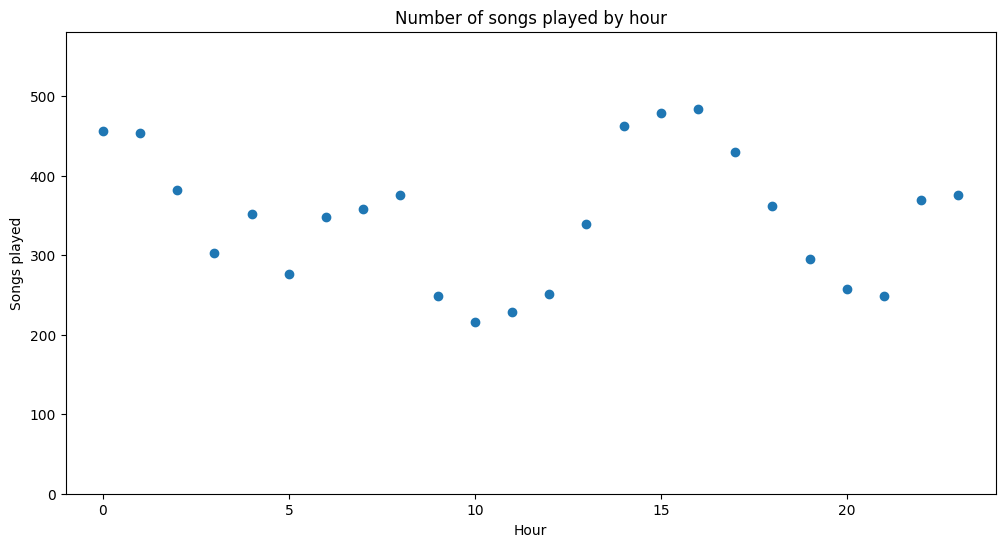

In [45]:
plt.figure(figsize=(12,6))
plt.scatter(songs_by_hour_pdDF["hour"], songs_by_hour_pdDF["count"])
plt.xlim(-1, 24)
plt.ylim(0, 1.2 * max(songs_by_hour_pdDF["count"]))
plt.title("Number of songs played by hour")
plt.xlabel("Hour")
plt.ylabel("Songs played")
plt.show()

## Drop rows with missing values

In [48]:
# As you'll see, it turns out there are no missing values in the userID or session columns. But there are userID values that are empty strings.
# how = 'any' or 'all'. If 'any', drop a row if it contains any nulls. If 'all', drop a row only if all its values are null.
# subset = list of columns to consider
user_log_valid_df = user_log.dropna(how = "any", subset = ["userId", "sessionId"])
user_log_valid_df.count()

10000

We see that there are no rows with NA values in `userId` or `sessionId` but, let's see that there are empty values for `userId`:

In [55]:
user_log_valid_df = user_log_valid_df.filter(user_log_valid_df.userId != '')
user_log_valid_df.count()

9664

### Store unique IDs in a dataframe

In [56]:
usersIDs = user_log_valid_df.select('userId').dropDuplicates().toPandas()

,userId
0,2904
1,691
2,2294
3,2162
4,1436
...,...
958,1389
959,1779
960,438
961,699


### Users Downgrade Their Accounts

We will find when users who downgraded their accounts and then we will flag those log entries. 

Then use a window function and cumulative sum to distinguish each user's data as either pre or post-downgrade events.

In [60]:
user_log_valid_df.select('page').dropDuplicates().show()

+----------------+
|            page|
+----------------+
|Submit Downgrade|
|            Home|
|       Downgrade|
|          Logout|
|   Save Settings|
|           About|
|        Settings|
|        NextSong|
|            Help|
|         Upgrade|
|           Error|
|  Submit Upgrade|
+----------------+



In [74]:
# create a function to flag downgrade event
flag_downgrade_event = udf(lambda x: 1 if x == 'Submit Downgrade' else 0, IntegerType())
user_log_valid_df = user_log_valid_df.withColumn('downgraded', flag_downgrade_event('page'))
user_log_valid_df.head(1)


[Row(artist='Showaddywaddy', auth='Logged In', firstName='Kenneth', gender='M', itemInSession=112, lastName='Matthews', length=232.93342, level='paid', location='Charlotte-Concord-Gastonia, NC-SC', method='PUT', page='NextSong', registration=1509380319284, sessionId=5132, song='Christmas Tears Will Fall', status=200, ts=1513720872284, userAgent='"Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', userId='1046', hour='22', downgrade=0, downgraded=0)]

In [77]:
# Partition by user id
# Then use a window function and cumulative sum to distinguish each user's data as either pre or post downgrade events.
windowval = Window.partitionBy("userId").orderBy(desc("ts")).rangeBetween(Window.unboundedPreceding, 0)

In [ ]:
# Fsum is a cumulative sum over a window - in this case a window showing all events for a user
# Add a column called phase, 0 if the user hasn't downgraded yet, 1 if they have
user_log_valid_df = user_log_valid_df.withColumn("phase", Fsum("downgraded").over(windowval))

In [76]:
user_log_valid_df.select(["userId", "firstname", "ts", "page", "level", "phase"]).where(user_log.userId == "1138").sort("ts").collect()

[Row(userId='1138', firstname='Kelly', ts=1513729066284, page='Home', level='paid', phase=1),
 Row(userId='1138', firstname='Kelly', ts=1513729066284, page='NextSong', level='paid', phase=1),
 Row(userId='1138', firstname='Kelly', ts=1513729313284, page='NextSong', level='paid', phase=1),
 Row(userId='1138', firstname='Kelly', ts=1513729552284, page='NextSong', level='paid', phase=1),
 Row(userId='1138', firstname='Kelly', ts=1513729783284, page='NextSong', level='paid', phase=1),
 Row(userId='1138', firstname='Kelly', ts=1513730001284, page='NextSong', level='paid', phase=1),
 Row(userId='1138', firstname='Kelly', ts=1513730263284, page='NextSong', level='paid', phase=1),
 Row(userId='1138', firstname='Kelly', ts=1513730518284, page='NextSong', level='paid', phase=1),
 Row(userId='1138', firstname='Kelly', ts=1513730768284, page='NextSong', level='paid', phase=1),
 Row(userId='1138', firstname='Kelly', ts=1513731182284, page='NextSong', level='paid', phase=1),
 Row(userId='1138', firs